In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [8]:
# !pip install numpy
# !pip install matplotlib
# !pip install graphviz

In [9]:
class Value:
    def __init__(self, data, children=(), op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.prev = set(children)
        self.op = op
        self.label = label
                
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other  = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other  = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out    

    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,), f'**{other}')
        
        def _backward():
            self.grad += other*self.data**(other-1) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * (other**-1)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        return out
        
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def backward(self):
        topo = []
        visited = set()
        
        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    topo_sort(child)
                topo.append(v)
                
        topo_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [10]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n.op:
            dot.node(name=str(id(n)) + n.op, label=n.op)
            dot.edge(str(id(n)) + n.op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    
    return dot

In [11]:
x1 = Value(2.0,label='x1')
x2 = Value(0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o'

o.backward()

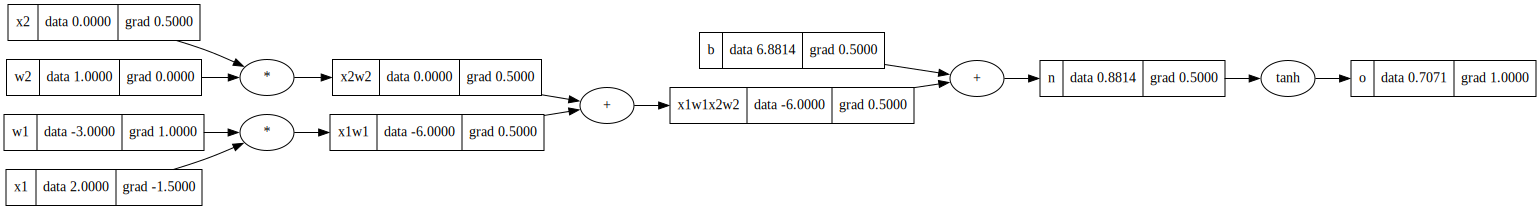

In [12]:
draw_dot(o)

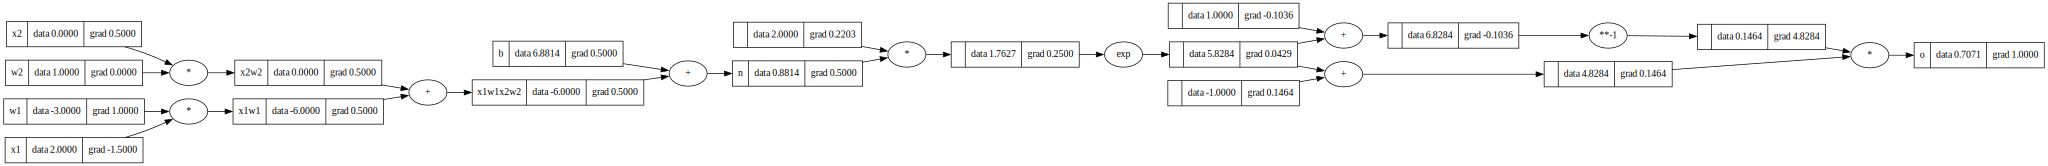

In [13]:
x1 = Value(2.0,label='x1')
x2 = Value(0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
# o = n.tanh(); o.label='o'
# --------------------
e = (2*n).exp()
o =(e-1) / (e+1)
# --------------------

o.label = 'o'
o.backward()
draw_dot(o)

In [14]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [15]:
# pip install torch torchvision torchaudio

In [16]:
x1 = torch.Tensor([2.0]).double()          ;x1.requires_grad=True
x2 = torch.Tensor([0.0]).double()          ;x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double()         ;w1.requires_grad=True
w2 = torch.Tensor([1.0]).double()          ;w2.requires_grad=True
b = torch.Tensor([6.88137]).double()       ;b.requires_grad=True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)
print(o.data.item())

o.backward()

print('-------')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('b', b.grad.item())

0.7071050214706146
-------
x1 -1.500007465833125
w1 1.0000049772220834
x2 0.5000024886110417
w2 0.0
b 0.5000024886110417


In [17]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [18]:
sum([1,2,3],9)

15

In [19]:
import random

In [20]:
class Neuron:
    
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        #w*x+b
        act = sum([wi*xi for wi, xi in zip(self.w,x)],self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            p = neuron.parameters()
            params.extend(p)
        return params
    
    
class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            p = layer.parameters()
            params.extend(p)
        return params
    
x = [1.0,2.0,3.0]
nin = 3
nouts = [4,4,1]
n = MLP(nin,nouts)
n(x)

Value(data=0.5141121002147024, grad=0.0)

In [21]:
# draw_dot(n(x))

In [22]:
xs = [
     [2.0,3,0,-1.0],
     [3.0,-1.0,0.5],
     [0.5,1.0,1.0],
     [1.0,1.0,-1.0]
        ]
ys = [1.0,-1.0,-1.0,1.0]

In [23]:
## initial loss
ypred = [n(x) for x in xs]
loss = sum([(ygt-yout)**2 for ygt, yout in zip(ys,ypred)])
loss

Value(data=5.3775248057475205, grad=0.0)

In [24]:
## n.parameters()

In [25]:
## len(n.parameters())

In [26]:
# loss.backward()

In [27]:
## update the weights
# for p in n.parameters():
#     p.data -= 0.05*p.grad

In [28]:
## recalculate the loss
# ypred = [n(x) for x in xs]
# loss = sum([(ygt-yout)**2 for ygt, yout in zip(ys,ypred)])
# loss

In [29]:
# n.layers[0].neurons[0].w[0]

In [30]:
# n.layers[0].neurons[0].w[0]

In [31]:
ypred

[Value(data=0.9225177588299119, grad=0.0),
 Value(data=0.6000771098732127, grad=0.0),
 Value(data=0.66324438470487, grad=0.0),
 Value(data=0.7881211023761776, grad=0.0)]

In [32]:
ys

[1.0, -1.0, -1.0, 1.0]

In [33]:
iters = 20
lr = 0.1

for k in range(iters):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(ygt-yout)**2 for ygt, yout in zip(ys,ypred)])
    
    # zero grad before backprop
    for p in n.parameters():
        p.grad = 0
    # backpropogation
    loss.backward()
    
    # update parameters
    for p in n.parameters():
        p.data -= lr*p.grad
    
    print(k,'loss', loss.data)

0 loss 5.3775248057475205
1 loss 2.882644261447628
2 loss 2.441637158672691
3 loss 2.234259187120631
4 loss 1.8745888073871484
5 loss 0.17780988944457676
6 loss 0.09252397316932742
7 loss 0.07663044157656516
8 loss 0.06601632649685976
9 loss 0.058113917082355346
10 loss 0.0519211916754868
11 loss 0.0469116905339738
12 loss 0.04276655076208881
13 loss 0.039276286658545365
14 loss 0.03629577400132453
15 loss 0.033720575476841416
16 loss 0.03147330706612159
17 loss 0.029495269387314494
18 loss 0.02774106089821654
19 loss 0.02617497958594421


In [34]:
ypred

[Value(data=0.9251120911516642, grad=-0.1497758176966717),
 Value(data=-0.9108398737884963, grad=0.17832025242300742),
 Value(data=-0.9143093177620228, grad=0.1713813644759543),
 Value(data=0.9273752138329736, grad=-0.14524957233405278)]

# Everything from scratch

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, children=(), op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.prev = set(children)
        self.op = op
        self.label = label
    
    def __add__(self,other):
        other  = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other  = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out    

    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self,), f'**{other}')
        
        def _backward():
            self.grad += other*self.data**(other-1) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * (other**-1)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        return out
        
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __radd__(self,other):
        return self + other
    
    def __rsub__(self,other):
        return other + (-self)
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def backward(self):
        topo = []
        visited = set()
        
        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    topo_sort(child)
                topo.append(v)
                
        topo_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
class Neuron:
    
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        #w*x+b
        act = sum([wi*xi for wi, xi in zip(self.w,x)],self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    
class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            p = neuron.parameters()
            params.extend(p)
        return params
    
    
class MLP:
    
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            p = layer.parameters()
            params.extend(p)
        return params
    

In [4]:
nin = 3
nouts = [4,4,1]
n = MLP(nin,nouts)

In [5]:
xs = [
     [2.0,3,0,-1.0],
     [3.0,-1.0,0.5],
     [0.5,1.0,1.0],
     [1.0,1.0,-1.0]
        ]
ys = [1.0,-1.0,-1.0,1.0]


In [6]:
iters = 20
lr = 0.1

for k in range(iters):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(ygt-yout)**2 for ygt, yout in zip(ys,ypred)])
    
    # zero grad before backprop
    for p in n.parameters():
        p.grad = 0
    # backpropogation
    loss.backward()
    
    # update parameters
    for p in n.parameters():
        p.data -= lr*p.grad
    
    print(k,'loss', loss.data)

0 loss 5.174643078558459
1 loss 4.174484822999763
2 loss 3.5668873375506776
3 loss 3.070551207949395
4 loss 2.487635661891838
5 loss 1.8603752485961038
6 loss 1.0387925688812307
7 loss 0.45562828671228284
8 loss 0.248108205068191
9 loss 0.15593840628160474
10 loss 0.11493687286265905
11 loss 0.09054812546007238
12 loss 0.07423753340902967
13 loss 0.06263400251266187
14 loss 0.05399496214696778
15 loss 0.047334879803721565
16 loss 0.0420569938693872
17 loss 0.03778004400833567
18 loss 0.03424968341539669
19 loss 0.03129007765417559


In [7]:
ypred

[Value(data=0.9127867166657941, grad=-0.17442656666841172),
 Value(data=-0.9097325537392074, grad=0.18053489252158528),
 Value(data=-0.9071179693983237, grad=0.18576406120335265),
 Value(data=0.9168817865861681, grad=-0.1662364268276637)]

In [ ]:
c